In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lets upload the data set from google drive. and run some checks to make sure the data is how i want them: Just as the previous ones

In [2]:
import json

In [3]:
import os, shutil, pathlib

In [4]:
files = os.listdir("/content/drive/MyDrive/train")
print(len(files))

8005


In [5]:
print(files[:20])
print(files[-20:])

['dog.3006.jpg', 'dog.3007.jpg', 'dog.3008.jpg', 'dog.3009.jpg', 'dog.3010.jpg', 'dog.3011.jpg', 'dog.3012.jpg', 'dog.3013.jpg', 'dog.3014.jpg', 'dog.3015.jpg', 'dog.3016.jpg', 'dog.3017.jpg', 'dog.3018.jpg', 'dog.3019.jpg', 'dog.3020.jpg', 'dog.3021.jpg', 'dog.3022.jpg', 'dog.3023.jpg', 'dog.3024.jpg', 'dog.3025.jpg']
['cat.991.jpg', 'cat.992.jpg', 'cat.993.jpg', 'cat.994.jpg', 'cat.995.jpg', 'cat.996.jpg', 'cat.997.jpg', 'cat.998.jpg', 'cat.999.jpg', 'cat.1000.jpg', 'cat.1001.jpg', 'cat.1002.jpg', 'cat.1003.jpg', 'cat.1004.jpg', 'cat.1005.jpg', 'cat.1.jpg', 'cat.2.jpg', 'cat.3.jpg', 'cat.4.jpg', 'cat.5.jpg']


copying images to training, validation, and test directories:

In [6]:
original_dir = pathlib.Path("/content/drive/MyDrive/train")  #path to the directory where the original data was uncompressed.
new_base_dir = pathlib.Path("/content/drive/MyDrive/cats_vs_dogs_small") # directory where we will store our smaller dataset.

In [7]:

# def make_subset(subset_name, start_index, end_index):
#   for category in ("cat", "dog"):
#     dir = new_base_dir / subset_name / category
#     os.makedirs(dir, exist_ok=True)

#     all_files = sorted([f for f in os.listdir(original_dir) if f.startswith(category)])
#     selected_files = all_files[start_index:end_index]

#     for fname in selected_files:
#       dst = dir/fname
#       if dst.exists():
#         print(f"{dst} already exists")
#         continue
#       shutil.copyfile(src=original_dir / fname,
#                       dst=dir / fname)

# make_subset("train", start_index=0, end_index=1000)
# make_subset("validation", start_index=1000, end_index=1500)
# make_subset("test", start_index=1500, end_index=2000)

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

In [9]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Feature extraction with a pretrained model

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

Lets instantitate the VGG16 Convolutional Base

In [11]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


read the book for the explanation of the three arguments passed to the constructor.

lets view the detail architecture of the VGG16 convolutional base:

In [12]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

As you can see, the final feature map has shape(5, 5, 512). That is the feature map on top of which  we will stick a densely connected classifier.

At this point, we have two ways to proceed: Fast feature extraction without data augmentation and the feature extraction with data augmentation: which is more expensive.
lets start with the first one

## fast feature extraction without data augmentation

Lets iterate over our dataset to extract VGG16 features.

In [13]:
import numpy as np

In [ ]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
# lets check the shape of our features
#train_features.shape, val_features.shape, test_features.shape

It will be good to just save this features, so as to avoid feature extraction everytime i come back to run this again.

In [15]:
# np.save("/content/drive/MyDrive/train_features.npy", train_features)
# np.save("/content/drive/MyDrive/train_labels.npy", train_labels)

# np.save("/content/drive/MyDrive/val_features.npy", val_features)
# np.save("/content/drive/MyDrive/val_labels.npy", val_labels)

# np.save("/content/drive/MyDrive/test_features.npy", test_features)
# np.save("/content/drive/MyDrive/test_labels.npy", test_labels)

Now i can reload them back and continue.

In [16]:
train_features = np.load("/content/drive/MyDrive/train_features.npy")
train_labels = np.load("/content/drive/MyDrive/train_labels.npy")

val_features = np.load("/content/drive/MyDrive/val_features.npy")
val_labels = np.load("/content/drive/MyDrive/val_labels.npy")

test_features = np.load("/content/drive/MyDrive/test_features.npy")
test_labels = np.load("/content/drive/MyDrive/test_labels.npy")

We can now define our densely connected classifier. take note of the use of dropout and regularization. Then we train this classifier on the data and labels we recorder above.

In [17]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = "/content/drive/MyDrive/feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss"
)]

In [19]:
history = model.fit(train_features, train_labels,
                    epochs=20, validation_data=(val_features, val_labels),
                    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8707 - loss: 24.0117 - val_accuracy: 0.9370 - val_loss: 15.5149
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9822 - loss: 3.5569 - val_accuracy: 0.9630 - val_loss: 7.8650
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9731 - loss: 4.3368 - val_accuracy: 0.9700 - val_loss: 6.9315
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9875 - loss: 1.4537 - val_accuracy: 0.9750 - val_loss: 4.5949
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.2331 - val_accuracy: 0.9520 - val_loss: 8.8075
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9919 - loss: 1.2391 - val_accuracy: 0.9550 - val_loss: 7.1225
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9943 - loss: 0.4981 - val_accuracy: 0.9740 - val_loss: 6.7587
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0209 - val_accuracy: 0.9770 - val_l

In [20]:
model = keras.models.load_model("/content/drive/MyDrive/feature_extraction.keras")

Now lets plot and look at the loss and accuracy curve.

In [21]:
import matplotlib.pyplot as plt

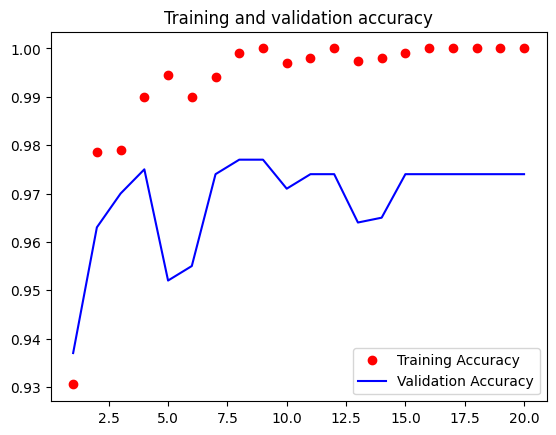

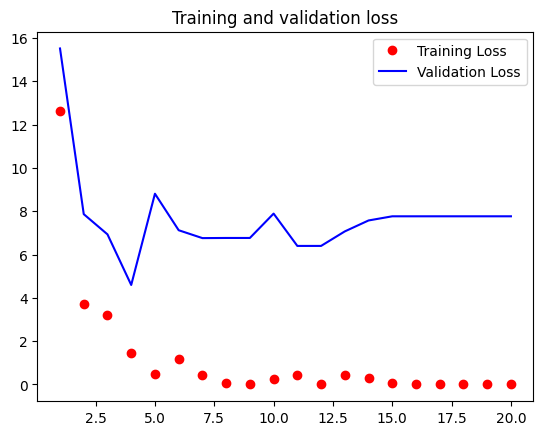

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'ro', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We reached a data augmentation of about 97%, much better than the previous model(with about 80 - 85%) trained form scratch. This is because the ImageNet contains instances of dogs and cats in it, meaning our pretrained model already has the exact knowledge required for this task at hand. This won't always be the case when using pretrained features.

Also, it's obvious that we have a case of overfitting, almost from the begining, and that is despite using Dropout with a fairly large rate. That is because this techniqu does not use data augmentation, which is essential for preventing overfitting with small image dataset.

### Feature extraction together with data augmentation

This, as mentioned earlier is much more slower and expensive, but allows us to use data augmentation during training: creating a model that chains the conv_base with a new dense classier, and training it end to end on the inputs.

In order to do it, we will first freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don't do this, the representations that were previosuly learned by the convolutional base will be modified during training. This is because the dense layers on top are randomly initialized, very large weights will be propagated through the network, effectively destroying the representations previously learned.

In keras, this is done by simply setting the layer or model's trainaible attributes to false.

In [23]:
#instantiating and freezing the VGG16 convolutional base.
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False)
conv_base.trainable = False

setting trainable to FALSE empties the list of trainable weights of the layer or model.

Lets print the list of trainable weights before and after freezing :

In [24]:
conv_base.trainable = True
print("the number of trainable weights before freezing: ", len(conv_base.trainable_weights))

conv_base.trainable = False
print("the number of trainable weights after freezing: ", len(conv_base.trainable_weights))

the number of trainable weights before freezing:  26
the number of trainable weights after freezing:  0


Now, we create a new model that chains together:
(1)A data augmentation stage
(2)our frozen convolutional base
(3) A dense classifier

#### Adding data augmentatin stage and a classifier to the convolutional base

In [25]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [28]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath = "/content/drive/MyDrive/feature_extraction_with_data_augmentation.keras",
    save_best_only = True,
    monitor = "val_loss"
)]

In [29]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks = callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 555s 9s/step - accuracy: 0.8545 - loss: 40.8621 - val_accuracy: 0.9600 - val_loss: 5.5384
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.9441 - loss: 7.7633 - val_accuracy: 0.9520 - val_loss: 9.9858
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.9586 - loss: 4.3411 - val_accuracy: 0.9580 - val_loss: 8.3588
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.9666 - loss: 4.4920 - val_accuracy: 0.9620 - val_loss: 7.2396
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.9650 - loss: 3.9935 - val_accuracy: 0.9670 - val_loss: 5.4289
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9692 - loss: 3.6930 - val_accuracy: 0.9690 - val_loss: 4.2278
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.9733 - loss: 2.6850 - val_accuracy: 0.9710 - val_loss: 5.7707
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.9701 - loss: 3.1154 - val_accur

Note: Only run this training using GPU because this technique is expensive and takes a lot of time.

to avoid running the training each time a run the notebook again, I will simply save the history:

In [30]:
#np.save("/content/drive/MyDrive/training_history.npy", history.history)

In [31]:
history_dict = np.load("/content/drive/MyDrive/training_history.npy",
    allow_pickle=True
).item()